# Homework 10: Missing Values

# Question 14.1

In [1]:
# Dependencies
if (!require("dplyr")) install.packages("dplyr") 
if (!require("ggplot2")) install.packages("ggplot2") 

rm(list=ls())
df <- read.table('breast-cancer-wisconsin.data.txt', stringsAsFactors = FALSE, sep=',')

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2


## 1. Mean/Mode Imputation

Begin by looking at the dataframe.   
This usually helps in a bunch of ways, like being able to see the general distribution of data, what kind of odd outliers might possibly exist, and so on. In this case, it is fairly simple and we are just looking for any potential missing values.

In [2]:
# Data summary
summary(df)
head(df)

       V1                 V2               V3               V4        
 Min.   :   61634   Min.   : 1.000   Min.   : 1.000   Min.   : 1.000  
 1st Qu.:  870688   1st Qu.: 2.000   1st Qu.: 1.000   1st Qu.: 1.000  
 Median : 1171710   Median : 4.000   Median : 1.000   Median : 1.000  
 Mean   : 1071704   Mean   : 4.418   Mean   : 3.134   Mean   : 3.207  
 3rd Qu.: 1238298   3rd Qu.: 6.000   3rd Qu.: 5.000   3rd Qu.: 5.000  
 Max.   :13454352   Max.   :10.000   Max.   :10.000   Max.   :10.000  
       V5               V6              V7                  V8        
 Min.   : 1.000   Min.   : 1.000   Length:699         Min.   : 1.000  
 1st Qu.: 1.000   1st Qu.: 2.000   Class :character   1st Qu.: 2.000  
 Median : 1.000   Median : 2.000   Mode  :character   Median : 3.000  
 Mean   : 2.807   Mean   : 3.216                      Mean   : 3.438  
 3rd Qu.: 4.000   3rd Qu.: 4.000                      3rd Qu.: 5.000  
 Max.   :10.000   Max.   :10.000                      Max.   :10.000  
      

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2
1017122,8,10,10,8,7,10,9,7,1,4


In [3]:
# Get missing index and row
missing.index <- which(df$V7 == '?')
missing.row <- df[missing.index,]
df.nomissing <- data.frame(df[-missing.index,])

# Count number of missing values
length(which(df == '?'))
length(missing.index)

[1] 16

[1] 16

As explained in the data notes and TA description, each feature is scaled from 1 to 10 other than V1 and V11. We can see how feature V7 is somewhat different than expected, and has non-numerical values in it (character).
  
We can see that there are 16 missing values in the column for V7. This also matches with the number of missing values, denoted by the '?', in the entire dataframe. Since this is much less than the standard 5% of the number of total values, we can try to impute the values using mean or mode as the homework says to do.

In [4]:
# Get mean and mode of V7
V7 <- as.numeric(df.nomissing$V7)
mean <- mean(V7)
mode <- 1

In [5]:
# Store in new dataframes with imputed values
df.mean <- df
df.mode <- df
df.mean[missing.index, 'V7'] <- mean
df.mode[missing.index, 'V7'] <- mode

## 2. Imputing with Regression

Here, we begin a typical regression modeling problem. As always, we want to validate and test our model before applying the predictions. Since we will actually be using the predictions this time, we want to be sure of how off they are from what they could possibly be.
  
Let us prepare

__DATA EXPLORATION__

There are so many things that can be done to optimize the linear regression model. One of the most basic things to do though, however, is to just look at the target feature. This makes sense since it is what we want to almost literally set our sights on.
  
Furthermore, since this is the feature we imputed on, there is actually a method for imputing values with non-Normal distributions. Essentially, you try out a bunch of imputation values fitting the distribution and then try out your models based on the different imputations as part of the validation process. For now, we are still on the imputing with regression part of this process. 

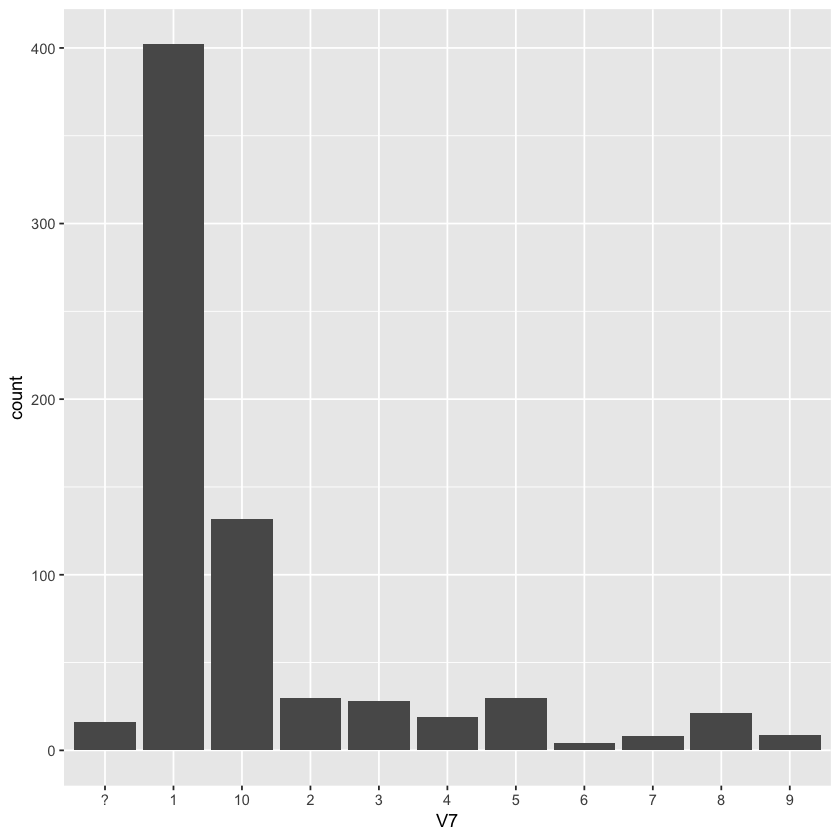

In [6]:
# Distribution of V7
ggplot(df, aes(x=V7)) + geom_bar()

__SETUP__

Fairly short one this time.
  
First, we define a useful function that will be used later on to calculate root mean squared error.  
Second, we can split the training and testing sets to make it easier for us to handle during the model building process. This is also helpful since it allows us to organize in our minds what will be happening as we validate. 

In [7]:
# Evaluate model on Root Mean Squared Error
# Inputs are log
RMSE <- function(y, yhat) {
    y <- exp(y)
    yhat <- exp(yhat)
    
    rmse <- sqrt(mean((y - yhat)^2))
    return(rmse)
}

Since the target feature is skewed to the right, we can try to just predict on the log of the variable. This will reduce the bias in the model, since the variance will be more centralized. 

In [8]:
# Data set for model building vs imputing
# Convert to numerical values
data <- transform(df.nomissing, V7 = log(as.numeric(V7)))
data.predict <- df[missing.index,]

In [9]:
# Split train and test sets
N <- nrow(data)
n <- round(N*0.7)
n.index <- sample(n)

train <- data[n.index,]
test <- data[-n.index,]

train.x <- train[,-7]
train.y <- train[,7]
val.x <- test[,-7]
val.y <- test[,7]

__MODEL BUILDING__

In [10]:
# Start with a simple, Generalized Linear Model
model1 <- glm(V7~., data=train)
summary(model1)


Call:
glm(formula = V7 ~ ., data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2377  -0.1979  -0.1154   0.2885   2.0936  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.113e+00  1.347e-01  -8.265 1.46e-15 ***
V1          -1.742e-07  8.735e-08  -1.994 0.046762 *  
V2           3.673e-03  1.242e-02   0.296 0.767540    
V3          -4.758e-03  2.117e-02  -0.225 0.822279    
V4           3.265e-02  2.074e-02   1.574 0.116061    
V5           3.536e-02  1.240e-02   2.851 0.004546 ** 
V6          -8.506e-03  1.595e-02  -0.533 0.594135    
V8           5.698e-02  1.618e-02   3.522 0.000471 ***
V9          -5.687e-03  1.198e-02  -0.475 0.635268    
V10         -1.823e-02  1.513e-02  -1.205 0.228838    
V11          6.512e-01  5.183e-02  12.565  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2819602)

    Null deviance: 482.33  on 477 

In [11]:
# Significant features
features <- c('V1', 'V2', 'V5', 'v8', 'V11')

# Model using significant features
model2 <- glm(V7~V1+V5+V8+V11, data=train)
summary(model2)


Call:
glm(formula = V7 ~ V1 + V5 + V8 + V11, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1762  -0.2021  -0.1257   0.2903   2.0742  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.181e+00  1.217e-01  -9.703  < 2e-16 ***
V1          -1.715e-07  8.644e-08  -1.984  0.04786 *  
V5           3.336e-02  1.178e-02   2.832  0.00482 ** 
V8           6.126e-02  1.527e-02   4.011 7.03e-05 ***
V11          6.835e-01  3.850e-02  17.755  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2816383)

    Null deviance: 482.33  on 477  degrees of freedom
Residual deviance: 133.21  on 473  degrees of freedom
AIC: 757.79

Number of Fisher Scoring iterations: 2


In [12]:
# Model using significant features
model3 <- glm(V7~V1+factor(V5)+factor(V8)+factor(V11), data=train)
summary(model3)


Call:
glm(formula = V7 ~ V1 + factor(V5) + factor(V8) + factor(V11), 
    data = train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.96966  -0.18561  -0.06791   0.23837   2.10492  

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.369e-01  1.060e-01   3.179  0.00158 ** 
V1           -1.901e-07  8.519e-08  -2.232  0.02612 *  
factor(V5)2   1.604e-01  8.770e-02   1.828  0.06815 .  
factor(V5)3   2.012e-01  9.203e-02   2.186  0.02929 *  
factor(V5)4   3.207e-01  1.142e-01   2.807  0.00521 ** 
factor(V5)5   5.828e-01  1.477e-01   3.947 9.17e-05 ***
factor(V5)6   2.597e-01  1.413e-01   1.838  0.06675 .  
factor(V5)7   3.366e-01  1.846e-01   1.824  0.06884 .  
factor(V5)8   3.853e-01  1.412e-01   2.730  0.00658 ** 
factor(V5)9   6.483e-01  3.064e-01   2.116  0.03488 *  
factor(V5)10  2.951e-01  1.144e-01   2.580  0.01018 *  
factor(V8)2  -1.062e-01  7.844e-02  -1.353  0.17659    
factor(V8)3   5.429e-02  7.363e-02   0.737  

For the sake of readability, I omit the step where I tried using V2 as part of the model and it came up as statistically insignificant to our model. Now, we have two models - one with 4 features and one with 10 features. We can try to test these raw models using the test set.

__MODEL VALIDATION__

In [13]:
# Predict on the validation set
pred1 <- predict(model1, val.x)
pred2 <- predict(model2, val.x)

In [14]:
RMSE(pred1, val.y)
RMSE(pred2, val.y)

[1] 1.870494

[1] 1.836715

So,  
It looks like our model2 is not only simpler, but it performed better in the validation. Out of a range 1 to 10, we can assume that our 'average' error is about 1.8 in either direction.

__IMPUTATION__

In [15]:
# Get values using model2
impute.values <- exp(predict(model2, data.predict))

In [16]:
df.impute <- df
df.impute[missing.index, 'V7'] <- impute.values

Now, we again make a nother dataframe to store the values with regression-based imputations. We can put the values in an now we have a complete data set!

## 3. Perburbation

Usually, the perturbations are done with random assignments of adding or subtracting the average error, as seen by the lecture. I wanted to explore another method, however, which wouldn't add to much complexity to all of this. This isn't exactly my area of expertise, but I thought it could be an interesting topic to explore.

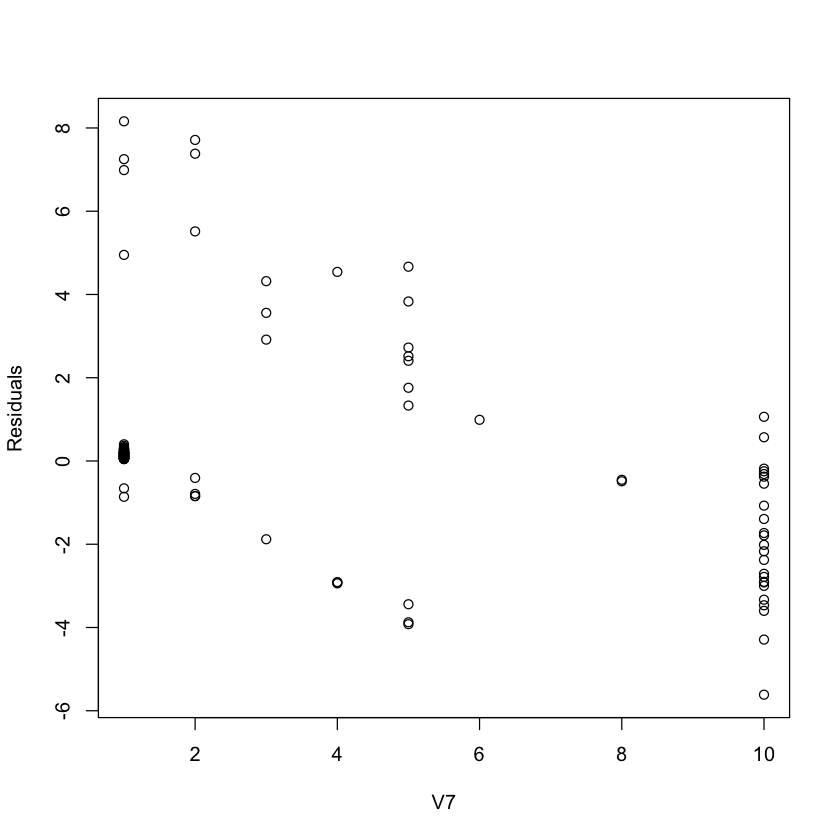

In [17]:
plot(x = exp(val.y),
     y = exp(pred2) - exp(val.y),
     xlab='V7', ylab='Residuals')

In [18]:
# Randomly add or minus the rmse
impute.pert <- vector()
for (i in 1:length(impute.values)) {
    if (sample(0:1,1) == 1) {
        impute.pert[i] <- impute.values[i] + 1.8
    }
    else {
        impute.pert[i] <- impute.values[i] - 1.8
    }
}

[1] 0

However, we see that the model is imperfect and seems to have a trend in the errors - for example, the predictions underestimate for larger values of V7. The average mark seems to be around 3.5 so how about we do the same as before, but instead of randomly perturbating, adjust according to the trend? 
  
This probably isn't considered perturbation anymore, since we aren't really adding any noise. This also might be a gross overfit. 

In [20]:
# Randomly add or minus the rmse
impute.pert.adj <- vector()
for (i in 1:length(impute.values)) {
    if (impute.values[i] > 6.2) {
        impute.pert.adj[i] <- impute.values[i] + 1.8
    }
    if (impute.values[i] < 2.7) {
        impute.pert.adj[i] <- impute.values[i] - 1.8
    }
}

In [21]:
impute.pert.adj

[1]  8.0577108  0.2684655 -0.6510949 -0.6514089 -0.7212947 -0.5814988
 [7] -0.5906004 -0.3465623 -0.4933117  8.2055149 -0.5315791 -0.4074372
[13] -0.1342411 -0.4806131 -0.6619224 -0.6957254

In [22]:
impute.pert

[1]  8.0577108  3.8684655 -0.6510949 -0.6514089  2.8787053  3.0185012
 [7] -0.5906004 -0.3465623 -0.4933117  4.6055149 -0.5315791 -0.4074372
[13] -0.1342411 -0.4806131  2.9380776 -0.6957254

In [24]:
# Fill in the missing entries with imputed values
df.pert <- df
df.pert.adj <- df

df.pert[missing.index, 'V7'] <- impute.pert
df.pert.adj[missing.index, 'V7'] <- impute.pert.adj

### Summary

We now have several dataframes with various imputation techniques - Mean, Mode, Linear Regression, Perturbated LR, and my so-called Perturbated Linear Regression Adj. 

# Question 15.1

An optimization problem could be in cooking food - for example, an experiment on baking the best tasting cake with limitations on the cost and health.

Imagine (some) of the ingredients to baking this hypothetical cake. While I am no expert in baking cakes from scratch, I know that some of the basic recipes involve sugar, eggs, water, oil, and flour.  
  
In our case, say that we want to bake the best tasting cake. We have data on multiple cakes that we have tried eating before, but also know the ingredients to. For the sake of our example, let us say that the data set is significant enough and that there is an appropriate measuring guideline for taste, such as rating the taste between 1-10. 

Possible constraints:
1. Sum of cost of ingredients < budget  
2. Volume of ingredients < pan size  
3. Mass of sugar < designated health restriction limit

The variables in this optimization model would be the amount of the ingredients themselves, with the cost being readily calculable. 